In [3]:
import gym
import ppaquette_gym_doom
import numpy as np
from ppaquette_gym_doom.wrappers import SetResolution, ToDiscrete
from gym.wrappers import SkipWrapper

# (see https://github.com/ppaquette/gym-doom/blob/master/ppaquette_gym_doom/doom_basic.py)
def create_env():
    return SetResolution('200x150')(
        SkipWrapper(repeat_count=4)(
        ToDiscrete('minimal')(gym.make('ppaquette/DoomBasic-v0'))))

env = create_env()
WIDTH, HEIGHT = env.screen_width, env.screen_height

NOOP, SHOOT, RIGHT, LEFT = 0, 1, 2, 3
SUCCESS = 100 - 10

[2017-03-01 20:16:05,087] Making new env: ppaquette/DoomBasic-v0


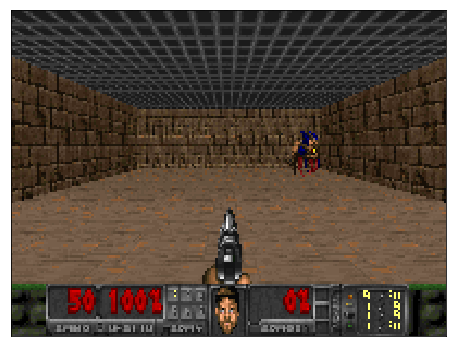

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

def show(observation):
    plt.figure(figsize=(8, 6))
    plt.imshow(observation, interpolation=None)
    plt.xticks([]); plt.yticks([]);

show(env.reset())

-10.0


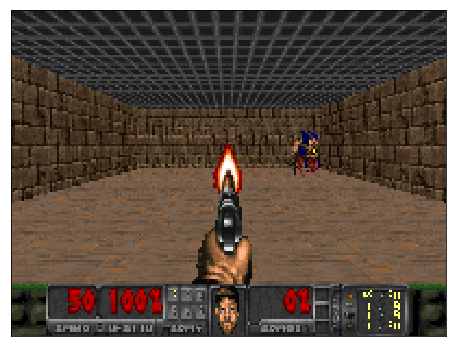

In [5]:
observation, reward, _, _ = env.step(action=SHOOT)
print(reward)
show(observation)

In [6]:
from gym import wrappers
from collections import namedtuple
import operator

SARE = namedtuple('SAR', ['state', 'action', 'reward', 'end'])


def play_episodes(env, agent, episode_count=100, max_episode_steps=10000, outdir=None, seed=None):
    if outdir is not None:
        env = wrappers.Monitor(env, directory=outdir, force=True)
    if seed is not None:
        env.seed(seed)

    reward = 0
    done = False

    for i in range(episode_count):
        observation = env.reset()
        while True:
            action = agent.act(observation, reward, done)
            new_observation, reward, done, _ = env.step(action)
            yield SARE(observation, action, reward, done)
            
            if done:
                break
            else:
                observation = new_observation
    env.close()

## Off-line Q-learning

In [7]:
import random

SUCCESS = 0

def to_experience_pairs(sares, n_misses=100):
    experiences = [
        (previous_s, a, r, next_s, end)
        for (previous_s, a, r, end), (next_s, _, _, _) in zip(sares[:-1], sares[1:])
    ]

    shuffled_exps = experiences
    if n_misses != None:
        shuffled_exps = random.choices(experiences, k=n_misses) + [e for e in experiences if e[2] > SUCCESS]
        random.shuffle(shuffled_exps)

    prev_frames, actions, rewards, next_frames, is_ends = zip(*shuffled_exps)
    prev_frames = np.asarray(prev_frames)
    next_frames = np.asarray(next_frames)
    actions = np.asarray(actions)
    rewards = np.asarray(rewards)
    is_ends = np.asarray(is_ends)
    
    print('Training on {}/{} success/total out of {} 1-step experiences with actions distribution {}'.format(
        np.sum(rewards>=SUCCESS),
        len(rewards),
        len(experiences),
        np.bincount(actions)))
    
    return (prev_frames, next_frames, actions, rewards, is_ends)

In [8]:
import tensorflow as tf
from keras import backend as K

sess = tf.InteractiveSession()
K.set_session(sess)

Using TensorFlow backend.


In [9]:
from keras.layers import Dense, Convolution2D, Flatten, Activation
from keras.models import Sequential
from keras.optimizers import Adam

def create_q_model(conv1_weights=None, conv2_weights=None, dense1_weights=None, dense2_weights=None):
    model = Sequential()

    model.add(Convolution2D(
        2, nb_row=6, nb_col=6, border_mode='valid', weights=conv1_weights,
        input_shape=[HEIGHT, WIDTH, 3], dim_ordering='tf'))
    model.add(Activation('relu'))
    model.add(Convolution2D(4, nb_row=2, nb_col=2, weights=conv2_weights))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(128, init='normal', activation='linear', weights=dense1_weights))
    model.add(Activation('relu'))
    model.add(Dense(4, init='normal', activation='linear', weights=dense2_weights))
    model.compile(loss='mse', optimizer='adam')
    
    return model

def copy_model(model):
    conv1_weights =  [w.eval() for w in model.layers[0].weights]
    conv2_weights = [w.eval() for w in model.layers[2].weights]
    dense1_weights = [w.eval() for w in model.layers[5].weights]
    dense2_weights = [w.eval() for w in model.layers[7].weights]
    return create_q_model(conv1_weights, conv2_weights, dense1_weights, dense2_weights)


acting_model = create_q_model()
target_model = create_q_model()

In [10]:
def sares_to_input_targets(model, sares, gamma = 1, reward_clip=5, n_misses=100):
    prev_frames, next_frames, actions, rewards, is_ends = to_experience_pairs(sares, n_misses)
    n_samples = len(actions)
    
    current_action_rewards = model.predict(prev_frames)
    target_action_rewards = current_action_rewards.copy()

    followed_action_targets = np.clip(rewards, -np.inf, reward_clip) + gamma * (1 - is_ends) * model.predict(next_frames).max(axis=1)
    target_action_rewards[np.arange(n_samples), actions] = followed_action_targets

    return prev_frames, target_action_rewards

In [ ]:
class EpsilonGreedyQAgent(object):
    def __init__(self, model, epsilon=.1):
        self.model = model
        self.epsilon = epsilon

    def act(self, observation, reward, done):
        if random.uniform(0, 1) <= self.epsilon:
            return random.choice([NOOP, SHOOT, LEFT, RIGHT])
        else:
            return self.model.predict(observation[np.newaxis])[0].argmax()

BATCH_SIZE = 32

env = create_env()

for _ in range(80):
    for _ in range(2):
        sares = list(play_episodes(env, EpsilonGreedyQAgent(acting_model, epsilon=.05), episode_count=10))
        print('average reward/episode = {}'.format(
            sum(r for _, _, r, _ in sares) / float(sum(e for _, _, _, e in sares))))
        prev_frames, target_action_rewards = sares_to_input_targets(target_model, sares, reward_clip=5, n_misses=200)
        acting_model.fit(x=prev_frames, y=target_action_rewards, batch_size=BATCH_SIZE, nb_epoch=1, verbose=0)
    target_model = copy_model(acting_model)
    
env.close()

[2017-03-01 20:16:14,339] Making new env: ppaquette/DoomBasic-v0


average reward/episode = -306.9
Training on 5/204 success/total out of 514 1-step experiences with actions distribution [  4 194   4   2]
average reward/episode = -238.0
Training on 6/205 success/total out of 430 1-step experiences with actions distribution [  3 171   1  30]
average reward/episode = -213.4
Training on 6/204 success/total out of 401 1-step experiences with actions distribution [  1 154   0  49]
average reward/episode = -226.8
Training on 5/204 success/total out of 449 1-step experiences with actions distribution [  3  47   0 154]
average reward/episode = -249.8
Training on 6/203 success/total out of 432 1-step experiences with actions distribution [  0 172   3  28]
average reward/episode = -269.4
Training on 5/204 success/total out of 465 1-step experiences with actions distribution [  7 165   1  31]
average reward/episode = -107.4
Training on 9/205 success/total out of 314 1-step experiences with actions distribution [ 23  25   6 151]
average reward/episode = -168.3
Tr

In [ ]:
import json
model_name = 'DoomBasic-v0_res=200x150_skip=4_discrete=minimal'

acting_model.save(model_name + '.h5')

with open(model_name + '.json') as f:
    json.dumps(f, acting_model.to_json())

In [22]:
n_episodes = 100
seed = 0

env = create_env()

sares = play_episodes(env, EpsilonGreedyQAgent(acting_model), episode_count=n_episodes, seed=seed, outdir='tmp/q_learning')
print('EpsilonGreedyQAgent average reward of {:.2f}'.format(sum(map(operator.attrgetter('reward'), sares))))


[2017-03-01 19:23:54,563] Making new env: ppaquette/DoomBasic-v0
[2017-03-01 19:23:54,577] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-03-01 19:23:54,578] Clearing 12 monitor files from previous run (because force=True was provided)
[2017-03-01 19:23:54,946] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/q_learning/openaigym.video.0.10255.video000000.mp4
[2017-03-01 19:23:55,462] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/q_learning/openaigym.video.0.10255.video000001.mp4
[2017-03-01 19:23:55,721] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/q_learning/openaigym.video.0.10255.video000008.mp4
[2017-03-01 19:23:56,531] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/q_learning/openaigym.video.0.1

EpsilonGreedyQAgent average reward of 7839.00


## Embedding viz

In [2]:
thumbnail_size = 150
n_frames = 1000
frames = prev_frames[:n_frames, :, :, :]
thumbnails = frames[:, :, 25:-25, :]
frame_embeddings = Sequential(acting_model.layers[:-1]).predict(frames)
frame_rewards = acting_model.predict(frames).max(1)

NameError: name 'prev_frames' is not defined

In [ ]:
from tensorflow.contrib.tensorboard.plugins import projector
import scipy.misc
import os

LOG_DIR = '/tmp/rl-study'

def images_to_sprite(data):
    """Creates the sprite image along with any necessary padding
    From https://github.com/tensorflow/tensorflow/issues/6322
    Args:
      data: NxHxW[x3] tensor containing the images.

    Returns:
      data: Properly shaped HxWx3 image with any necessary padding.
    """
    if len(data.shape) == 3:
        data = np.tile(data[...,np.newaxis], (1,1,1,3))
    data = data.astype(np.float32)
    min = np.min(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) - min).transpose(3,0,1,2)
    max = np.max(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) / max).transpose(3,0,1,2)
    # Inverting the colors seems to look better for MNIST
    #data = 1 - data

    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, 0),
            (0, 0)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=0)
    # Tile the individual thumbnails into an image.
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3)
            + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    data = (data * 255).astype(np.uint8)
    return data



output_path = os.path.join(LOG_DIR, 'embed')
  
summary_writer = tf.summary.FileWriter(output_path, sess.graph)
config = projector.ProjectorConfig()
embed_tensor = tf.Variable(frame_embeddings, name=('frames'))
sess.run(embed_tensor.initializer)

embedding = config.embeddings.add()
embedding.tensor_name = embed_tensor.name
#embedding.metadata_path = os.path.join(output_path, 'labels.tsv')
embedding.sprite.image_path = os.path.join(output_path, 'sprite.png')
embedding.sprite.single_image_dim.extend([thumbnail_size, thumbnail_size])

projector.visualize_embeddings(summary_writer, config)
result = sess.run(embed_tensor)

saver = tf.train.Saver([embed_tensor])
saver.save(sess, os.path.join(output_path, 'model.ckpt'), global_step=0)

sprite = images_to_sprite(thumbnails)

scipy.misc.imsave(embedding.sprite.image_path, sprite)
#all_labels = np.array(all_labels).flatten()
#metadata_file = open(os.path.join(output_path, 'labels.tsv'), 'w')
#metadata_file.write('Name\tClass\n')
#  for ll in xrange(len(all_labels)):
#    metadata_file.write('%06d\t%d\n' % (ll, all_labels[ll]))
#  metadata_file.close()

In [1]:
print(1)

1
